In [31]:
# hide
%reload_ext autoreload
%autoreload 2

In [32]:
from dataFunction import *
# import diffprivlib.models as dp
import numpy as np
import copy
from make_logreg_data import *
import random
import tensorflow as tf
from FL_utils import *
from HE_functions import *
from dataFunction import *
from typing import Generator
import tenseal as ts
from lrClass import LR
from simulationDataUtils import *
import seaborn as sns
from sklearn.linear_model import LinearRegression

random.seed(11007303)
np.random.seed(2021)

In [191]:
EPOCHS = 80
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [192]:
cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)


In [193]:
df_dict ={
    'Cleveland': cleveland_df,
    # 'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []

for i in list(df_dict.keys()):
    df = df_dict.get(i)
    location_data = new_df(df, False)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak', 'Cholesterol']
    for j in numeric_feature_names:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model)
    lr = 3
    lr_decay = 1
    clients.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL = KL_matrices_disc_cont(clients, cat_bin_features, numeric_feature_names)
KL_mean = (np.array(KL)[np.triu_indices(len(clients), k=1)].mean() + np.array(KL)[np.tril_indices(len(clients), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients:
    i.make_dummies(cat_feat)
val_x, val_y = make_validation_sets(clients)

best_epoch, best_acc, model_dict, final_results, net_best = FL_proces(clients, val_x, val_y, ctx_eval, glob_model, 300)
print(df_dict.keys())
print(clients[0].X.columns)
print(KL)
print('KL FL mean: {}'.format(KL_mean))
print('Best model, iter: {}, acc: {}'.format(best_epoch, best_acc))  


dict_keys(['Cleveland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ChestPainType_1', 'ChestPainType_4',
       'ChestPainType_3', 'ChestPainType_2', 'RestingECG_2', 'RestingECG_0',
       'RestingECG_1', 'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2
0  0.000000  2.016075  2.445411
1  2.358766  0.000000  2.114656
2  1.519378  1.812092  0.000000
KL FL mean: 2.0443964321112524
Best model, iter: 82, acc: 0.8066666722297668


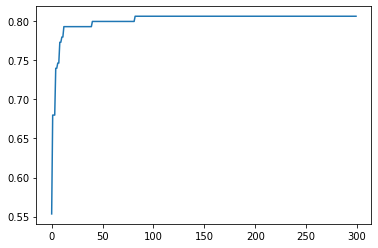

In [194]:
plt.plot(final_results.best_acc)
plt.show()

In [195]:
final_results

,epoch,loss_avg,loss_test,acc_test,best_acc
0,0.0,0.699050,11.098364,0.513333,0.553333
1,1.0,0.994712,1.610452,0.680000,0.680000
2,2.0,1.042780,1.617937,0.646667,0.680000
3,3.0,1.056109,1.537075,0.646667,0.680000
4,4.0,1.073893,1.089095,0.740000,0.740000
...,...,...,...,...,...
295,295.0,0.884777,0.954778,0.806667,0.806667
296,296.0,0.884709,0.862460,0.793333,0.806667
297,297.0,0.884465,0.897432,0.766667,0.806667
298,298.0,0.884126,0.884800,0.766667,0.806667


In [196]:
# for i in clients:
#     # print(i.X.Oldpeak)
#     xy = pd.concat([i.X, i.y], axis=1)
#     plt.figure(figsize=(12,10))
#     sns.heatmap(xy.corr(),annot=True,cmap="magma",fmt='.2f')
#     # print(xy)

In [197]:
df_dict_S ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients_S = []

for i in list(df_dict_S.keys()):
    df = df_dict_S.get(i)
    location_data = new_df(df)
    y = location_data.HeartDisease
    location_data = location_data.drop(columns="HeartDisease")

    numeric_feature_names_S = ['Age', 'MaxHR', 'RestingBP',  'Oldpeak']
    for j in numeric_feature_names_S:
        if location_data[j].std() != 0: 
            location_data[j] = (location_data[j] - location_data[j].mean()) / location_data[j].std()
    x = location_data
    glob_model_S = LR(len(x.columns))
    client_model = copy.deepcopy(glob_model_S)
    lr = 3
    lr_decay = 1
    clients_S.append(Client(i, x, y, client_model, lr, torch.nn.BCELoss(), None))
cat_bin_features = ['Sex', 'ChestPainType',  'FastingBS', 'RestingECG','ExerciseAngina', 'ST_Slope']
KL_S = KL_matrices_disc_cont(clients_S, cat_bin_features, numeric_feature_names_S)
KL_mean_S = (np.array(KL_S)[np.triu_indices(len(clients_S), k=1)].mean() + np.array(KL_S)[np.tril_indices(len(clients_S), -1)].mean()) /2
cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
for i in clients_S:
    i.make_dummies(cat_feat)
val_x_S, val_y_S = make_validation_sets(clients_S)

best_epoch_S, best_acc_S, model_dict_S, final_results_S, net_best_S = FL_proces(clients_S, val_x_S, val_y_S, ctx_eval, glob_model_S, 300)
print(df_dict_S.keys())
print(clients_S[0].X.columns)
print(KL_S)
print('KL FL mean: {}'.format(KL_mean_S))
print('Best model, iter: {}, acc: {}'.format(best_epoch_S, best_acc_S))  


dict_keys(['Cleveland', 'Switzerland', 'VA Long Beach', 'Hungary'])
Index(['Age', 'Sex', 'RestingBP', 'FastingBS', 'MaxHR', 'ExerciseAngina',
       'Oldpeak', 'ChestPainType_1', 'ChestPainType_4', 'ChestPainType_3',
       'ChestPainType_2', 'RestingECG_2', 'RestingECG_0', 'RestingECG_1',
       'ST_Slope_3', 'ST_Slope_2', 'ST_Slope_1'],
      dtype='object')
          0         1         2         3
0  0.000000  1.548866  2.016075  2.445411
1  1.371031  0.000000  0.662388  1.171660
2  2.358766  0.830447  0.000000  2.114656
3  1.519378  1.188149  1.812092  0.000000
KL FL mean: 1.5865767504716217
Best model, iter: 33, acc: 0.7771428823471069


In [206]:
(np.array(KL_S)[np.triu_indices(len(clients_S), k=1)].mean() + np.array(KL_S)[np.tril_indices(len(clients_S), -1)].mean()) /2

1.5865767504716217

In [199]:
final_results.iloc[[88]]

,epoch,loss_avg,loss_test,acc_test,best_acc
88,88.0,0.898663,0.876794,0.773333,0.806667


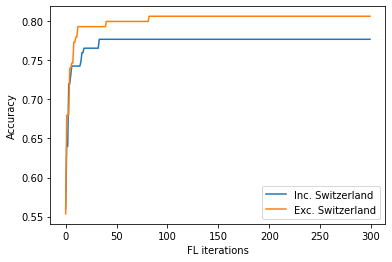

In [210]:
plt.plot(final_results_S.best_acc, label= 'Inc. Switzerland')
plt.plot(final_results.best_acc, label= 'Exc. Switzerland')
plt.ylabel('Accuracy')
plt.xlabel('FL iterations')
plt.legend()
# plt.show()
plt.savefig('../images/Accuracy_Healthcare',bbox_inches='tight',  dpi=300)
plt.savefig('/Users/Romy/Documents/Master Thesis/Thesis_latex/images/Accuracy_Healthcare', bbox_inches='tight',  dpi=300)

In [243]:
# Plot predicted vs test!

# import plotly.graph_objects as go
# net_best_S.load_state_dict(model_dict_S)
y_pred = net_best(val_x).detach().numpy()
y_test = val_y

y_pred_round =y_pred.round()

fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred_round[:,0],
                    mode='markers',
                    name='Pred'))

In [241]:
# Plot predicted vs test!

import plotly.graph_objects as go
# glob_model_S.load_state_dict(model_dict_S)
y_pred = net_best_S(val_x_S).detach().numpy()
y_test = val_y_S

y_pred_round =y_pred.round()

fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred_round[:,0],
                    mode='markers',
                    name='Pred'))

In [234]:
len(val_y_S)

175

In [220]:
glob_model_S.load_state_dict(model_dict_S)
y_pred = glob_model_S(val_x_S).detach().numpy()
y_test = val_y

y_pred_round =y_pred.round()

fig = go.Figure()
 
 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred_round[:,0],
                    mode='markers',
                    name='Pred'))

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0.])

In [228]:
y_pred_round[:,0]

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0.], dtype=float32)